Importing Libraries.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/musicgeneratedlstm/Melody_Snippet_Cleaned.wav
/kaggle/input/musicgeneratedlstm/Melody_Generated 2.wav
/kaggle/input/musicgeneratedlstm/Melody_Generated_1.wav
/kaggle/input/musicgeneratedlstm/Corpus_Snippet.wav
/kaggle/input/classical-music-midi/brahms/br_im2.mid
/kaggle/input/classical-music-midi/brahms/br_im5.mid
/kaggle/input/classical-music-midi/brahms/BR_IM6.MID
/kaggle/input/classical-music-midi/brahms/brahms_opus1_4.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus117_2.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus1_2.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus1_1.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus1_3.mid
/kaggle/input/classical-music-midi/brahms/br_rhap.mid
/kaggle/input/classical-music-midi/brahms/brahms_opus117_1.mid
/kaggle/input/classical-music-midi/granados/gra_esp_4.mid
/kaggle/input/classical-music-midi/granados/gra_esp_2.mid
/kaggle/input/classical-music-midi/granados/gra_esp_3.mid
/kaggle/input/class

In [2]:
#Installing dependencies
!pip install music21
!apt-get install -y lilypond

#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

     |████████████████████████████████| 19.2 MB 614 kB/s 
  Created wheel for music21: filename=music21-7.1.0-py3-none-any.whl size=21912606 sha256=54e48466d091b80c75cc2eb5a33a975be92d299f875673a60e9c94c2401d1724
  Stored in directory: /root/.cache/pip/wheels/98/3c/67/9e30a8a4c3ac934068c95d2c27e38e1b5e5016a9257dbbf5d0
Successfully built music21



The following additional packages will be installed:
  ghostscript gsfonts libauthen-sasl-perl libdata-dump-perl
  libencode-locale-perl libfile-listing-perl libfont-afm-perl
  libhtml-form-perl libhtml-format-perl libhtml-parser-perl
  libhtml-tagset-perl libhtml-tree-perl libhttp-cookies-perl
  libhttp-daemon-perl libhttp-date-perl libhttp-message-perl
  libhttp-negotiate-perl libio-html-perl libio-socket-ssl-perl
  liblwp-mediatypes-perl liblwp-protocol-https-perl libmailtools-perl
  libnet-http-perl libnet-smtp-ssl-perl libnet-ssleay-perl
  libtext-unidecode-perl libtimedate-perl libtry-tiny-perl liburi-perl
  libwww-perl libwww-robotrule

Loading Data.

In [3]:
#Loading the list of chopin's midi files as stream 
filepath = "../input/classical-music-midi/chopin/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [4]:
#Helping function (to get notes)        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))
    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 57887


In [5]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['6.10.1', 'F#2', 'F3', 'G#3', 'F#3', 'B-3', 'C#3', '6.10.1', 'F#2', 'F3', 'G#3', 'F#3', 'B-3', 'C#3', '6.10.1', 'F#2', 'F3', 'G#3', 'F#3', 'B-3', 'C#3', 'F4', 'B4', 'C#2', 'G3', 'B-3', 'G#3', 'G#4', 'B3', 'C#3', '6.10.1', 'F#2', 'F3', 'G#3', 'F#3', 'B-3', 'C#3', 'C#4', '6.10', 'F#2', 'F3', 'G#3', 'F#3', '6.10', 'B-3', 'C#3', 'C#4', '6.10', 'F#2', 'F3']


Data Exploration,

Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmpfjz2xf9f.ly'
Parsing...
Interpreting music...[8][16][24][32][32]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmpfjz2xf9f.ly.eps'...
Converting to PNG...
Layout output to `tmpfjz2xf9f.ly-1.eps'...
Layout output to `tmpfjz2xf9f.ly-2.eps'...
Layout output to `tmpfjz2xf9f.ly-3.eps'...
Layout output to `tmpfjz2xf9f.ly-4.eps'...
Layout output to `tmpfjz2xf9f.ly-5.eps'...
Writing tmpfjz2xf9f.ly-systems.texi...
Writing tmpfjz2xf9f.ly-systems.tex...
Writing tmpfjz2xf9f.ly-systems.count...
Success: compilation successfully completed


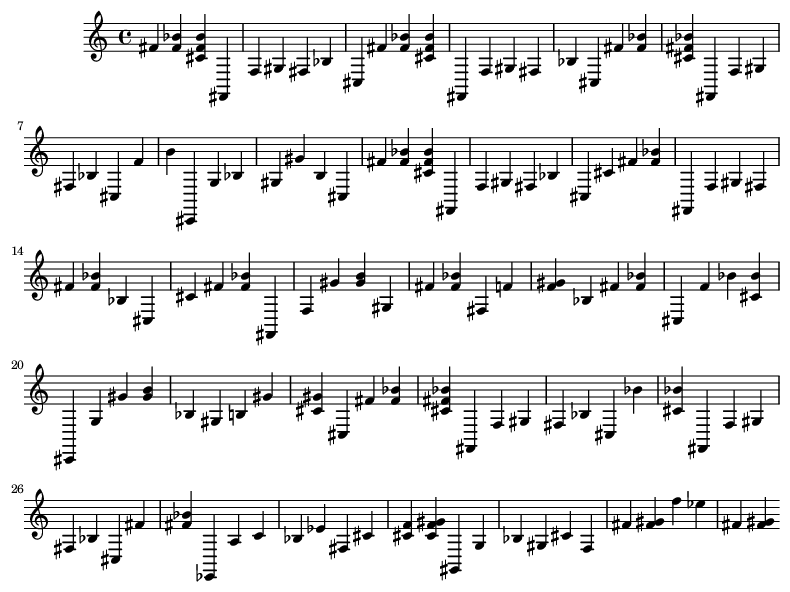

In [6]:
# functions for data exploration

def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

In [7]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 397


In [8]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 145.8110831234257
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


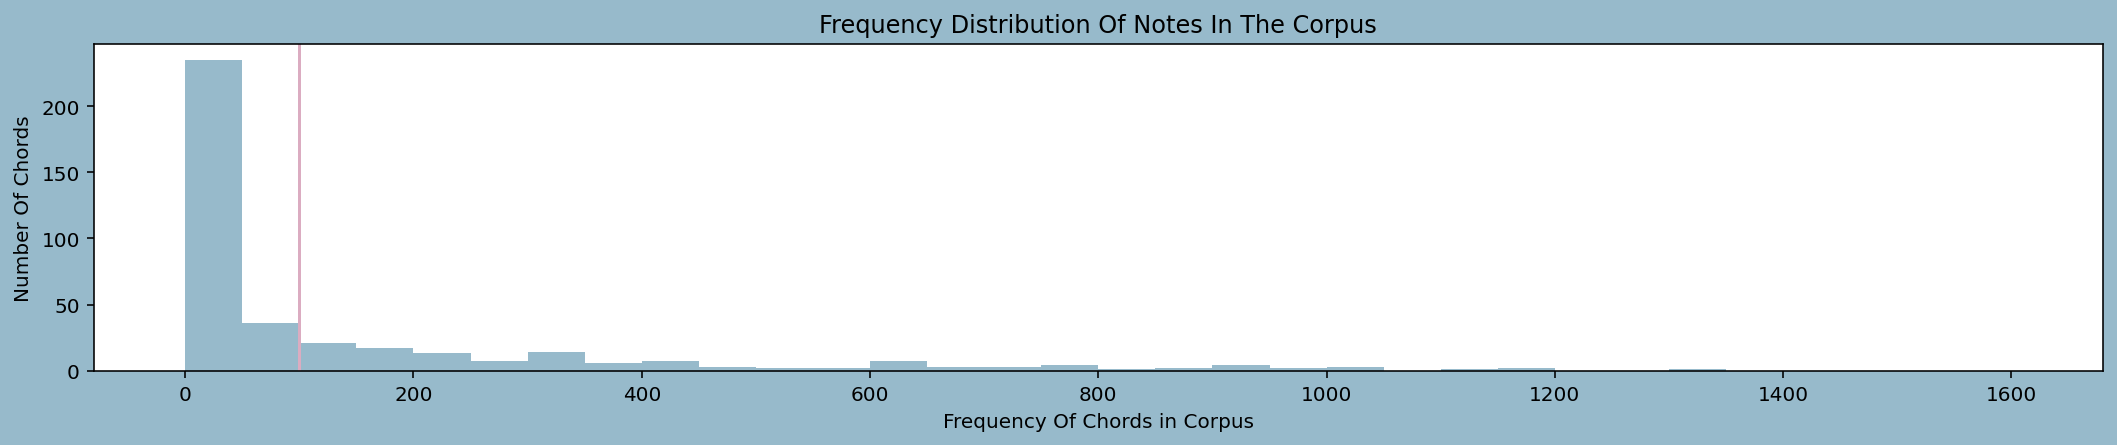

In [9]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

Data Preprocessing

In [10]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 271


In [11]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 53712


Creating a dictionary/list of sorted unique characters.

In [12]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53712
Number of unique characters: 266


In [13]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 53672


In [14]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

Splitting train and seed datasets.

In [15]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

Model Building

In [16]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

2021-10-26 08:15:59.408214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 08:15:59.537123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 08:15:59.538791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 08:15:59.543226: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
#Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 512)           1052672   
_________________________________________________________________
dropout (Dropout)            (None, 40, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 266)               68362     
Total params: 1,974,282
Trainable params: 1,974,282
Non-trainable params: 0
______________________________________________

In [18]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

2021-10-26 08:16:04.258441: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-10-26 08:16:08.616847: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


168/168 [==============================] - 11s 31ms/step - loss: 4.7145
Epoch 2/200
168/168 [==============================] - 5s 31ms/step - loss: 4.5349
Epoch 3/200
168/168 [==============================] - 5s 31ms/step - loss: 4.4775
Epoch 4/200
168/168 [==============================] - 5s 31ms/step - loss: 4.4500
Epoch 5/200
168/168 [==============================] - 5s 32ms/step - loss: 4.4356
Epoch 6/200
168/168 [==============================] - 5s 31ms/step - loss: 4.4300
Epoch 7/200
168/168 [==============================] - 5s 31ms/step - loss: 4.4240
Epoch 8/200
168/168 [==============================] - 5s 31ms/step - loss: 4.4256
Epoch 9/200
168/168 [==============================] - 5s 31ms/step - loss: 4.4195
Epoch 10/200
168/168 [==============================] - 5s 31ms/step - loss: 4.4035
Epoch 11/200
168/168 [==============================] - 5s 33ms/step - loss: 4.3912
Epoch 12/200
168/168 [==============================] - 5s 32ms/step - loss: 4.3894
Epoch 13/200

Model Evaluation

[Text(0.5, 0, 'Epochs')]

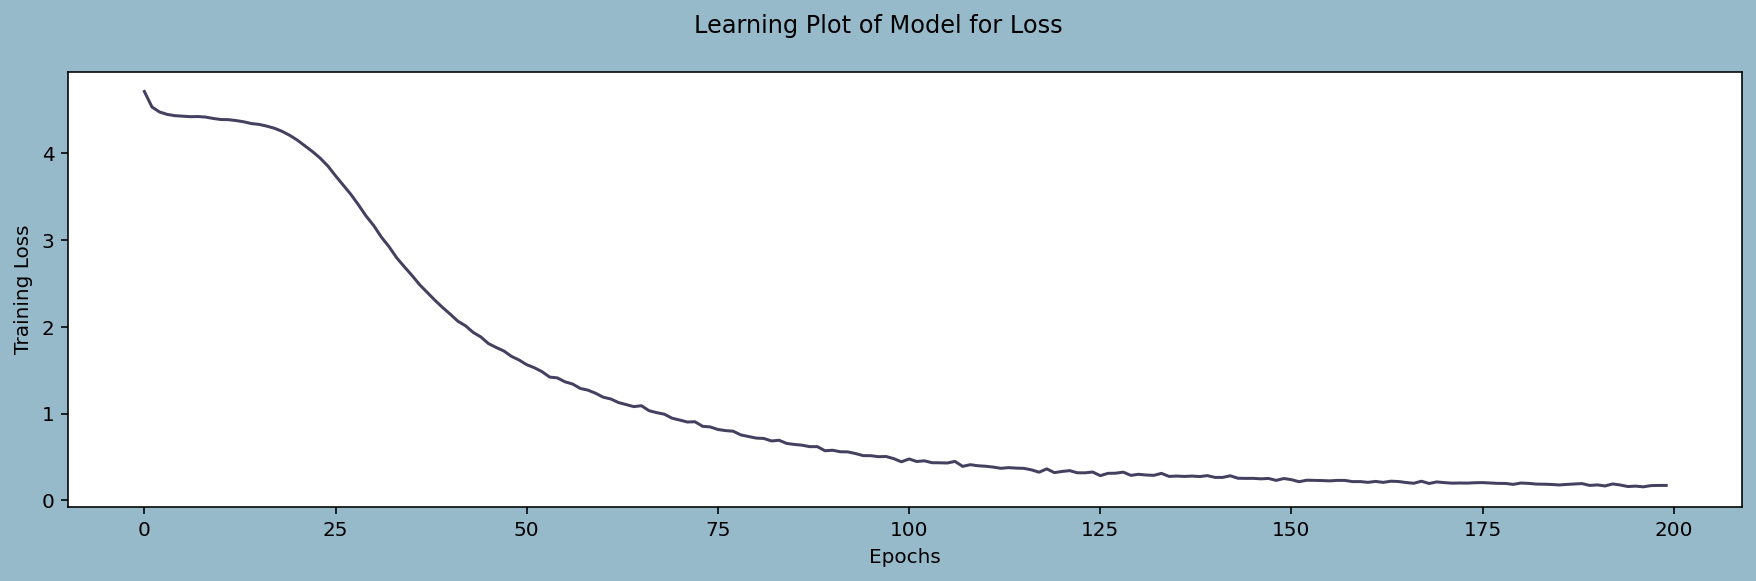

In [19]:
#Plotting the learning curve for loss function
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmplhz9kqx0.ly'
Parsing...
Interpreting music...[8][16][24][32][40]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmplhz9kqx0.ly.eps'...
Converting to PNG...
Layout output to `tmplhz9kqx0.ly-1.eps'...
Layout output to `tmplhz9kqx0.ly-2.eps'...
Layout output to `tmplhz9kqx0.ly-3.eps'...
Layout output to `tmplhz9kqx0.ly-4.eps'...
Layout output to `tmplhz9kqx0.ly-5.eps'...
Layout output to `tmplhz9kqx0.ly-6.eps'...
Writing tmplhz9kqx0.ly-systems.texi...
Writing tmplhz9kqx0.ly-systems.tex...
Writing tmplhz9kqx0.ly-systems.count...
Success: compilation successfully completed


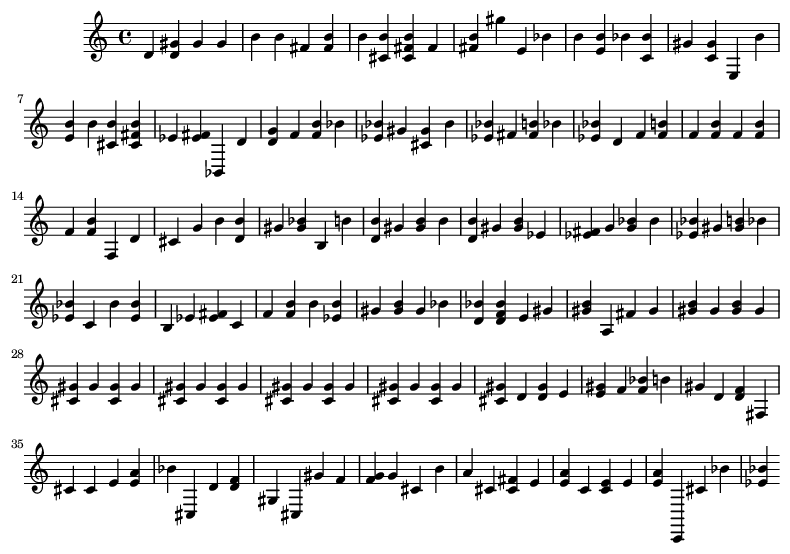

In [20]:
def Melody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Melody_Generator(100)
show(Melody)

Sample:

In [21]:
#To save the generated melody
Melody.write('midi','Melody_Generated.mid')

'Melody_Generated.mid'

The music doesn't have to hold true to the grammatical syntax, unlike the lyrics project. The question - is it a good musical composition; is it artsy? Did the LSTM create a masterpiece? I don't really know. I am not a connoisseur of music. I used a basic RNN and it worked alright, so there's that.